In [1]:
import os
import shutil
import json

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib_venn import venn2


PROTEIN_NAME = "Spike"
SITESMAPPING_FILE = "data/sitesMapping.csv"

OUTPUT_DIR = "output"
PARAFIXSITES_FILE = os.path.join(OUTPUT_DIR, "nextstrain_sitePath_results.csv")
HYPHY_RES_FILE = os.path.join(OUTPUT_DIR, "nextstrain_hyphy_results.csv")
STRUCTURE_DIR = os.path.join(OUTPUT_DIR, "structures", PROTEIN_NAME)
if os.path.exists(STRUCTURE_DIR):
    shutil.rmtree(STRUCTURE_DIR)
os.mkdir(STRUCTURE_DIR)
JOINT_RESULT_FILE = os.path.join(OUTPUT_DIR, "joint_result.csv")
TARGET_SITES_FILE = os.path.join(STRUCTURE_DIR, "target_sites.json")

PLOTS_DIR = "plots"
VENN_PLOT = os.path.join(PLOTS_DIR, "venn_graph.pdf")
MONTHLY_PLOT = os.path.join(PLOTS_DIR, "monthly.pdf")

PROTEIN_DOMAIN = {
    "RBD": [i for i in range(319, 541 + 1)],
    "NTD": [i for i in range(13, 303 + 1)],
    "S2": [i for i in range(686, 1273 + 1)],
    "FP": [i for i in range(816, 855 + 1)],
    "HR1": [i for i in range(920, 970 + 1)],
    "HR2": [i for i in range(1163, 1202 + 1)]
}

DOMAIN_COLOR = {
    "Seq": "#BCBDBD",
    "NTD": "#9BCAC8",
    "RBD": "#C6716B",
    "S2": "#9EC9A1",
    "FP": "#BAD3E1",
    "HR1": "#F0D0CE",
    "HR2": "#F0D0CE"
}

TYPE_COLORS = {
    "fixation": "teal",
    "parallel": "pink",
    "paraFix": "gold",
    "hyphy": "teal",
    "both": "red",
}


In [2]:
sites_mapping = pd.read_csv(SITESMAPPING_FILE, index_col=0)

paraFix_sites = pd.read_csv(PARAFIXSITES_FILE)
paraFix_sites = paraFix_sites.rename(columns={"product": "protein"})
paraFix_sites = paraFix_sites[paraFix_sites["protein"] == PROTEIN_NAME]
paraFix_sites["date"] = pd.to_datetime(paraFix_sites["date"])
paraFix_sites = paraFix_sites.sort_values("date")
paraFix_sites = paraFix_sites[["date", "protein", "aaPos", "paraFixMut"]]

hyphy_sites = pd.read_csv(HYPHY_RES_FILE)
hyphy_sites = hyphy_sites[hyphy_sites["protein"] == PROTEIN_NAME]
hyphy_sites["date"] = pd.to_datetime(hyphy_sites["date"])
hyphy_sites["positive_selection"] = hyphy_sites["p-value"] < 0.1
hyphy_sites = hyphy_sites.rename(columns={"site": "aaPos"})

df = pd.merge(paraFix_sites, hyphy_sites, on=("aaPos", "date", "protein"), how="outer")
df["paraFix_site"] = ~df["paraFixMut"].isna()


In [3]:
df["mutType"] = "neither"
df.loc[df["paraFix_site"] & df["positive_selection"], "mutType"] = "both"
df.loc[df["paraFix_site"] & (~df["positive_selection"]), "mutType"] = "paraFix"
df.loc[(~df["paraFix_site"]) & df["positive_selection"], "mutType"] = "hyphy"
df = df[df["mutType"] != "neither"]


In [4]:
df.to_csv(JOINT_RESULT_FILE, index=False)

In [5]:
both_type = df.loc[df["mutType"] == "both", "aaPos"].unique()
all_hyphy = df.loc[df["mutType"] != "paraFix", "aaPos"].unique()
all_paraFix = df.loc[df["mutType"] != "hyphy", "aaPos"].unique()

with open(TARGET_SITES_FILE, "w") as f:
    json.dump({
        "hyphy": list(int(i) for i in all_hyphy),
        "paraFix": list(int(i) for i in all_paraFix),
        "both": list(int(i) for i in both_type)
    }, f)

df["typeOrder"] = 0
df.loc[df["mutType"] == "hyphy", "typeOrder"] = 1
df.loc[df["mutType"] == "paraFix", "typeOrder"] = 2
# df.loc[df["mutType"] == "both", "typeOrder"] = 3
df = df.sort_values("typeOrder")


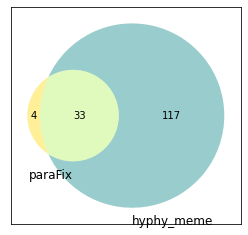

In [6]:
venn2(
    subsets = [set(all_paraFix), set(all_hyphy)],
    set_labels = ("paraFix", "hyphy_meme"),
    set_colors=(TYPE_COLORS["paraFix"], TYPE_COLORS["hyphy"]),
    alpha = 0.4
)
plt.savefig(VENN_PLOT, bbox_inches="tight")
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.show()
plt.close()


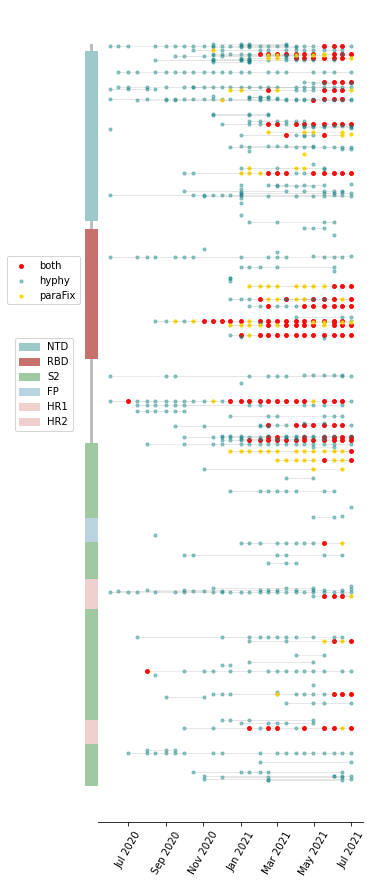

In [7]:
site_label = sites_mapping[["peptidePos", "aaPos", "gene", "genomePos", "product"]].drop_duplicates()
site_label["domain"] = "Seq"
site_label = site_label[site_label["gene"] == "Spike"]
for domain_name, sites in PROTEIN_DOMAIN.items():
    site_label.loc[site_label["aaPos"].isin(sites), "domain"] = domain_name

allDates = list(df["date"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    figsize=(5, 15),
    gridspec_kw={ "width_ratios": [1, 20], "hspace": 0 }
)

ax = axes[0]
for name, group in site_label.groupby("domain", sort=False):
    if name == "Seq":
        ax.fill_between(
            [0.4, 0.6],
            min(group["aaPos"]),
            max(group["aaPos"]),
            # label=name,
            color=DOMAIN_COLOR[name]
        )
    else:
        ax.fill_between(
            [0, 1],
            min(group["aaPos"]),
            max(group["aaPos"]),
            label=name,
            color=DOMAIN_COLOR[name],
            # capstyle="round",
            # joinstyle="round"
        )
ax.axis("off")
ax.legend(bbox_to_anchor=(-0.5, 0.6))
ax.invert_yaxis()

plt.subplots_adjust(wspace = .001)

ax = axes[1]
for mutType, group in df.groupby("mutType", sort=False):
    ax.scatter(
        group["date"],
        group["aaPos"],
        s=10 if mutType != "both" else 15,
        alpha=0.4 if mutType == "hyphy" else 1,
        c=TYPE_COLORS[mutType],
        label=mutType
    )
for site, info in df.groupby("aaPos"):
    info = info.sort_values("date")
    prev_index = -float("inf")
    prev_d = None
    for d in info["date"].values:
        curr_index = allDates.index(d)
        if curr_index - prev_index > 1:
            linestyles="dashed"
        else:
            linestyles="solid"
        if prev_d:
            ax.hlines(
                y=site,
                xmin=prev_d,
                xmax=d,
                colors="grey",
                alpha=0.4,
                linewidth=0.5,
                linestyles=linestyles
            )
        prev_d = d
        prev_index = curr_index
ax.legend(bbox_to_anchor=(-0.05, 0.7))
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_yticks([])
ax.set_yticklabels([])
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
ax.tick_params(axis='x', labelrotation=60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig(MONTHLY_PLOT, bbox_inches="tight")
plt.show()
plt.close()
